In [1]:
%matplotlib inline

In [2]:
import os

os.chdir("..")

In [3]:
from neuralforecast.models import NBEATS
from neuralforecast import NeuralForecast
from utils import load_dataset, train_test_split
from models.NBeatsMoe import NBeatsMoe, NBEATSMoEBlock
import torch.nn as nn
import pandas as pd

# datasets list
datasets = [
    {
        "name": "m3",
        "directory": "C:\\Users\\ricar\\mixture_of_experts_time_series\\data\\m3\\",
        "group": "Monthly",
        "freq": "M",
    },
    # {
    #     "name": "m4",
    #     "directory": "C:\\Users\\ricar\\mixture_of_experts_time_series\\data\\m4\\",
    #     "group": "Monthly",
    #     "freq": "M",
    # } 
]

c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-23 02:46:48,397	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-04-23 02:46:48,692	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [4]:
# Y_ALL_m4 = load_dataset("m4", datasets[1])
# Y_ALL_m3 = load_dataset("m3", datasets[0])
n_lags = 36
horizon = 18

Let's define the models and the gates to evaluate ...

In [5]:
from neuralforecast.losses.numpy import smape

def calculate_smape(Y_test, predictions, model_name):
    y_true = Y_test['y'].values
    y_hat = predictions[model_name].values

    n_series = Y_test['unique_id'].nunique()
    y_true = y_true.reshape(n_series, -1)
    y_hat = y_hat.reshape(n_series, -1)

    smape_value = smape(y_true, y_hat)
    return smape_value

In [9]:
results = []
gate_type_list = ["no_gate", "linear", "mlp", "conv1d-flatten", "conv1d-gap"]

for gate_type in gate_type_list:
    for dataset in datasets:
        
        # Load dataset
        Y_ALL = load_dataset(dataset["name"], dataset)
        # Train test split
        Y_train, Y_test = train_test_split(Y_ALL, horizon)
        
        for i in range(10):
            # Define model
            if gate_type == "no_gate":
                model = NBEATS(
                    h=horizon,
                    input_size=n_lags,
                    mlp_units=3*[[256,256]],
                    max_steps=5000,
                    early_stop_patience_steps=10,
                    random_seed=i
                )
            else:
                model = NBeatsMoe(
                    h=horizon,
                    input_size=n_lags,
                    nr_experts=4,
                    top_k=2,
                    mlp_units=3*[[128,128]],
                    gate_type=gate_type,
                    max_steps=5000,
                    early_stop_patience_steps=10,
                    random_seed=i,
                )
            
            # Define NeuralForecast, fit and predict
            nf = NeuralForecast(models=[model], freq=dataset["freq"])
            nf.fit(df=Y_train, static_df=None, val_size=horizon)
            predictions = nf.predict(futr_df=Y_test)
            
            # Calculate SMAPE
            smape_value = calculate_smape(Y_test, predictions, model_name=model.__class__.__name__)
            
            # Save result
            results.append({
                "dataset": dataset["name"],
                "gate_type": gate_type,
                "smape": smape_value,
                "random_seed": i,
            })

# Create and display the results DataFrame
results_df = pd.DataFrame(results)
results_df

Loading m3_monthly dataset...


Seed set to 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 655 K  | train
-------------------------------------------------------
653 K     Trainable params
2.0 K     Non-trainable params
655 K     Total params
2.622     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 39: 100%|██████████| 45/45 [00:04<00:00, 11.08it/s, v_num=195, train_loss_step=339.0, train_loss_epoch=471.0, valid_loss=656.0]  


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 86.70it/s]

Seed set to 1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 655 K  | train
-------------------------------------------------------
653 K     Trainable params
2.0 K     Non-trainable params
655 K     Total params
2.622     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 42:  22%|██▏       | 10/45 [00:01<00:04,  7.04it/s, v_num=197, train_loss_step=385.0, train_loss_epoch=476.0, valid_loss=657.0]


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 82.70it/s]

Seed set to 2


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 655 K  | train
-------------------------------------------------------
653 K     Trainable params
2.0 K     Non-trainable params
655 K     Total params
2.622     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 64:  44%|████▍     | 20/45 [00:02<00:02,  9.47it/s, v_num=199, train_loss_step=462.0, train_loss_epoch=441.0, valid_loss=669.0] 


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 94.96it/s] 

Seed set to 3


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 655 K  | train
-------------------------------------------------------
653 K     Trainable params
2.0 K     Non-trainable params
655 K     Total params
2.622     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 59: 100%|██████████| 45/45 [00:03<00:00, 12.37it/s, v_num=201, train_loss_step=399.0, train_loss_epoch=441.0, valid_loss=665.0] 


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 89.24it/s]


Seed set to 4
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 655 K  | train
-------------------------------------------------------
653 K     Trainable params
2.0 K     Non-trainable params
655 K     Total params
2.622     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 53:  33%|███▎      | 15/45 [00:01<00:03,  9.02it/s, v_num=203, train_loss_step=432.0, train_loss_epoch=470.0, valid_loss=669.0]


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 92.05it/s]

Seed set to 5


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 655 K  | train
-------------------------------------------------------
653 K     Trainable params
2.0 K     Non-trainable params
655 K     Total params
2.622     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 53:  33%|███▎      | 15/45 [00:01<00:03,  9.28it/s, v_num=205, train_loss_step=478.0, train_loss_epoch=455.0, valid_loss=667.0]  


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 71.24it/s]


Seed set to 6
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 655 K  | train
-------------------------------------------------------
653 K     Trainable params
2.0 K     Non-trainable params
655 K     Total params
2.622     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 33:  33%|███▎      | 15/45 [00:01<00:03,  8.50it/s, v_num=207, train_loss_step=494.0, train_loss_epoch=521.0, valid_loss=666.0] 


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 94.15it/s] 

Seed set to 7


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 655 K  | train
-------------------------------------------------------
653 K     Trainable params
2.0 K     Non-trainable params
655 K     Total params
2.622     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 51:  11%|█         | 5/45 [00:01<00:09,  4.21it/s, v_num=209, train_loss_step=389.0, train_loss_epoch=427.0, valid_loss=667.0]  


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 80.19it/s]


Seed set to 8
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 655 K  | train
-------------------------------------------------------
653 K     Trainable params
2.0 K     Non-trainable params
655 K     Total params
2.622     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 33:  33%|███▎      | 15/45 [00:01<00:03,  8.69it/s, v_num=211, train_loss_step=393.0, train_loss_epoch=509.0, valid_loss=655.0]


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 88.04it/s]


Seed set to 9
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 655 K  | train
-------------------------------------------------------
653 K     Trainable params
2.0 K     Non-trainable params
655 K     Total params
2.622     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 71:  11%|█         | 5/45 [00:00<00:07,  5.06it/s, v_num=213, train_loss_step=453.0, train_loss_epoch=422.0, valid_loss=666.0]   


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 70.27it/s]
Loading m3_monthly dataset...


100%|██████████| 1.76M/1.76M [00:00<00:00, 10.1MiB/s]
INFO:datasetsforecast.utils:Successfully downloaded M3C.xls, 1757696, bytes.
Seed set to 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 719 K  | train
-------------------------------------------------------
717 K     Trainable params
2.0 K     Non-trainable params
719 K     Total params
2.880     Total estimated model params size (MB)
106       Modules in train mode
0         Modules in eval mode


Epoch 53:  33%|███▎      | 15/45 [00:03<00:06,  4.45it/s, v_num=215, train_loss_step=436.0, train_loss_epoch=472.0, valid_loss=694.0]  


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 56.20it/s]

Seed set to 1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 719 K  | train
-------------------------------------------------------
717 K     Trainable params
2.0 K     Non-trainable params
719 K     Total params
2.880     Total estimated model params size (MB)
106       Modules in train mode
0         Modules in eval mode


Epoch 42:  22%|██▏       | 10/45 [00:02<00:08,  4.34it/s, v_num=217, train_loss_step=390.0, train_loss_epoch=476.0, valid_loss=674.0]


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 48.94it/s]

Seed set to 2


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 719 K  | train
-------------------------------------------------------
717 K     Trainable params
2.0 K     Non-trainable params
719 K     Total params
2.880     Total estimated model params size (MB)
106       Modules in train mode
0         Modules in eval mode


Epoch 42:  22%|██▏       | 10/45 [00:02<00:07,  4.73it/s, v_num=219, train_loss_step=578.0, train_loss_epoch=436.0, valid_loss=670.0] 


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:01<00:00, 44.98it/s]

Seed set to 3


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 719 K  | train
-------------------------------------------------------
717 K     Trainable params
2.0 K     Non-trainable params
719 K     Total params
2.880     Total estimated model params size (MB)
106       Modules in train mode
0         Modules in eval mode


Epoch 73:  33%|███▎      | 15/45 [00:02<00:04,  6.10it/s, v_num=221, train_loss_step=337.0, train_loss_epoch=444.0, valid_loss=674.0] 


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 54.52it/s]


Seed set to 4
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 719 K  | train
-------------------------------------------------------
717 K     Trainable params
2.0 K     Non-trainable params
719 K     Total params
2.880     Total estimated model params size (MB)
106       Modules in train mode
0         Modules in eval mode


Epoch 66:  67%|██████▋   | 30/45 [00:04<00:02,  7.18it/s, v_num=223, train_loss_step=498.0, train_loss_epoch=447.0, valid_loss=681.0]


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 46.94it/s]

Seed set to 5


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 719 K  | train
-------------------------------------------------------
717 K     Trainable params
2.0 K     Non-trainable params
719 K     Total params
2.880     Total estimated model params size (MB)
106       Modules in train mode
0         Modules in eval mode


Epoch 64:  44%|████▍     | 20/45 [00:03<00:04,  5.96it/s, v_num=225, train_loss_step=500.0, train_loss_epoch=449.0, valid_loss=671.0]


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 50.10it/s]

Seed set to 6


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 719 K  | train
-------------------------------------------------------
717 K     Trainable params
2.0 K     Non-trainable params
719 K     Total params
2.880     Total estimated model params size (MB)
106       Modules in train mode
0         Modules in eval mode


Epoch 33:  33%|███▎      | 15/45 [00:02<00:05,  5.71it/s, v_num=227, train_loss_step=501.0, train_loss_epoch=531.0, valid_loss=671.0] 


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 47.41it/s]


Seed set to 7
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 719 K  | train
-------------------------------------------------------
717 K     Trainable params
2.0 K     Non-trainable params
719 K     Total params
2.880     Total estimated model params size (MB)
106       Modules in train mode
0         Modules in eval mode


Epoch 51:  11%|█         | 5/45 [00:01<00:12,  3.24it/s, v_num=229, train_loss_step=394.0, train_loss_epoch=428.0, valid_loss=670.0]  


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 51.34it/s]

Seed set to 8


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 719 K  | train
-------------------------------------------------------
717 K     Trainable params
2.0 K     Non-trainable params
719 K     Total params
2.880     Total estimated model params size (MB)
106       Modules in train mode
0         Modules in eval mode


Epoch 33:  33%|███▎      | 15/45 [00:02<00:05,  5.77it/s, v_num=231, train_loss_step=395.0, train_loss_epoch=497.0, valid_loss=664.0]


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 49.74it/s]


Seed set to 9
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 719 K  | train
-------------------------------------------------------
717 K     Trainable params
2.0 K     Non-trainable params
719 K     Total params
2.880     Total estimated model params size (MB)
106       Modules in train mode
0         Modules in eval mode


Epoch 39: 100%|██████████| 45/45 [00:06<00:00,  7.23it/s, v_num=233, train_loss_step=359.0, train_loss_epoch=474.0, valid_loss=669.0]  


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 49.29it/s]
Loading m3_monthly dataset...


Seed set to 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 728 K  | train
-------------------------------------------------------
726 K     Trainable params
2.0 K     Non-trainable params
728 K     Total params
2.914     Total estimated model params size (MB)
109       Modules in train mode
0         Modules in eval mode


Epoch 59: 100%|██████████| 45/45 [00:06<00:00,  7.30it/s, v_num=235, train_loss_step=402.0, train_loss_epoch=456.0, valid_loss=675.0]  


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 59.20it/s]


Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 728 K  | train
-------------------------------------------------------
726 K     Trainable params
2.0 K     Non-trainable params
728 K     Total params
2.914     Total estimated model params size (MB)
109       Modules in train mode
0         Modules in eval mode


Epoch 42:  22%|██▏       | 10/45 [00:02<00:07,  4.71it/s, v_num=237, train_loss_step=392.0, train_loss_epoch=481.0, valid_loss=677.0]


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:01<00:00, 35.09it/s]


Seed set to 2
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 728 K  | train
-------------------------------------------------------
726 K     Trainable params
2.0 K     Non-trainable params
728 K     Total params
2.914     Total estimated model params size (MB)
109       Modules in train mode
0         Modules in eval mode


Epoch 64:  44%|████▍     | 20/45 [00:03<00:03,  6.52it/s, v_num=239, train_loss_step=468.0, train_loss_epoch=446.0, valid_loss=669.0] 


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 50.17it/s]


Seed set to 3
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 728 K  | train
-------------------------------------------------------
726 K     Trainable params
2.0 K     Non-trainable params
728 K     Total params
2.914     Total estimated model params size (MB)
109       Modules in train mode
0         Modules in eval mode


Epoch 39: 100%|██████████| 45/45 [00:06<00:00,  6.55it/s, v_num=241, train_loss_step=332.0, train_loss_epoch=479.0, valid_loss=660.0] 


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:01<00:00, 41.73it/s]

Seed set to 4


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 728 K  | train
-------------------------------------------------------
726 K     Trainable params
2.0 K     Non-trainable params
728 K     Total params
2.914     Total estimated model params size (MB)
109       Modules in train mode
0         Modules in eval mode


Epoch 55:  56%|█████▌    | 25/45 [00:03<00:02,  7.45it/s, v_num=243, train_loss_step=575.0, train_loss_epoch=452.0, valid_loss=682.0]


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 75.29it/s]


Seed set to 5
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 728 K  | train
-------------------------------------------------------
726 K     Trainable params
2.0 K     Non-trainable params
728 K     Total params
2.914     Total estimated model params size (MB)
109       Modules in train mode
0         Modules in eval mode


Epoch 64:  44%|████▍     | 20/45 [00:02<00:03,  6.92it/s, v_num=245, train_loss_step=502.0, train_loss_epoch=450.0, valid_loss=671.0]


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 58.48it/s]


Seed set to 6
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 728 K  | train
-------------------------------------------------------
726 K     Trainable params
2.0 K     Non-trainable params
728 K     Total params
2.914     Total estimated model params size (MB)
109       Modules in train mode
0         Modules in eval mode


Epoch 37:  78%|███████▊  | 35/45 [00:04<00:01,  8.08it/s, v_num=247, train_loss_step=514.0, train_loss_epoch=482.0, valid_loss=662.0] 


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 59.42it/s]


Seed set to 7
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 728 K  | train
-------------------------------------------------------
726 K     Trainable params
2.0 K     Non-trainable params
728 K     Total params
2.914     Total estimated model params size (MB)
109       Modules in train mode
0         Modules in eval mode


Epoch 51:  11%|█         | 5/45 [00:01<00:09,  4.05it/s, v_num=249, train_loss_step=392.0, train_loss_epoch=431.0, valid_loss=661.0]  


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 63.31it/s]

Seed set to 8


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 728 K  | train
-------------------------------------------------------
726 K     Trainable params
2.0 K     Non-trainable params
728 K     Total params
2.914     Total estimated model params size (MB)
109       Modules in train mode
0         Modules in eval mode


Epoch 33:  33%|███▎      | 15/45 [00:02<00:04,  6.83it/s, v_num=251, train_loss_step=396.0, train_loss_epoch=508.0, valid_loss=667.0] 


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 65.47it/s]

Seed set to 9


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 728 K  | train
-------------------------------------------------------
726 K     Trainable params
2.0 K     Non-trainable params
728 K     Total params
2.914     Total estimated model params size (MB)
109       Modules in train mode
0         Modules in eval mode


Epoch 48:  89%|████████▉ | 40/45 [00:04<00:00,  8.10it/s, v_num=253, train_loss_step=430.0, train_loss_epoch=472.0, valid_loss=659.0]  


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 77.02it/s]
Loading m3_monthly dataset...


Seed set to 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 719 K  | train
-------------------------------------------------------
717 K     Trainable params
2.0 K     Non-trainable params
719 K     Total params
2.880     Total estimated model params size (MB)
112       Modules in train mode
0         Modules in eval mode


Epoch 39: 100%|██████████| 45/45 [00:06<00:00,  7.20it/s, v_num=255, train_loss_step=340.0, train_loss_epoch=470.0, valid_loss=670.0]  


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 49.30it/s]

Seed set to 1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 719 K  | train
-------------------------------------------------------
717 K     Trainable params
2.0 K     Non-trainable params
719 K     Total params
2.880     Total estimated model params size (MB)
112       Modules in train mode
0         Modules in eval mode


Epoch 37:  78%|███████▊  | 35/45 [00:05<00:01,  6.74it/s, v_num=257, train_loss_step=450.0, train_loss_epoch=491.0, valid_loss=672.0]


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 67.42it/s]


Seed set to 2
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 719 K  | train
-------------------------------------------------------
717 K     Trainable params
2.0 K     Non-trainable params
719 K     Total params
2.880     Total estimated model params size (MB)
112       Modules in train mode
0         Modules in eval mode


Epoch 35:  56%|█████▌    | 25/45 [00:03<00:02,  8.13it/s, v_num=259, train_loss_step=419.0, train_loss_epoch=502.0, valid_loss=671.0] 


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 74.13it/s]

Seed set to 3


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 719 K  | train
-------------------------------------------------------
717 K     Trainable params
2.0 K     Non-trainable params
719 K     Total params
2.880     Total estimated model params size (MB)
112       Modules in train mode
0         Modules in eval mode


Epoch 37:  78%|███████▊  | 35/45 [00:03<00:01,  8.86it/s, v_num=261, train_loss_step=485.0, train_loss_epoch=484.0, valid_loss=670.0] 


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 60.43it/s]

Seed set to 4


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 719 K  | train
-------------------------------------------------------
717 K     Trainable params
2.0 K     Non-trainable params
719 K     Total params
2.880     Total estimated model params size (MB)
112       Modules in train mode
0         Modules in eval mode


Epoch 64:  44%|████▍     | 20/45 [00:02<00:03,  7.47it/s, v_num=263, train_loss_step=417.0, train_loss_epoch=443.0, valid_loss=675.0]


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 61.39it/s]

Seed set to 5


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 719 K  | train
-------------------------------------------------------
717 K     Trainable params
2.0 K     Non-trainable params
719 K     Total params
2.880     Total estimated model params size (MB)
112       Modules in train mode
0         Modules in eval mode


Epoch 51:  11%|█         | 5/45 [00:02<00:18,  2.16it/s, v_num=265, train_loss_step=389.0, train_loss_epoch=431.0, valid_loss=667.0]   


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:01<00:00, 34.85it/s]


Seed set to 6
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 719 K  | train
-------------------------------------------------------
717 K     Trainable params
2.0 K     Non-trainable params
719 K     Total params
2.880     Total estimated model params size (MB)
112       Modules in train mode
0         Modules in eval mode


Epoch 51:  11%|█         | 5/45 [00:01<00:12,  3.19it/s, v_num=267, train_loss_step=504.0, train_loss_epoch=455.0, valid_loss=666.0]  


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:01<00:00, 43.97it/s]

Seed set to 7


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 719 K  | train
-------------------------------------------------------
717 K     Trainable params
2.0 K     Non-trainable params
719 K     Total params
2.880     Total estimated model params size (MB)
112       Modules in train mode
0         Modules in eval mode


Epoch 51:  11%|█         | 5/45 [00:01<00:12,  3.15it/s, v_num=269, train_loss_step=395.0, train_loss_epoch=429.0, valid_loss=672.0]  


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:01<00:00, 44.99it/s]

Seed set to 8


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 719 K  | train
-------------------------------------------------------
717 K     Trainable params
2.0 K     Non-trainable params
719 K     Total params
2.880     Total estimated model params size (MB)
112       Modules in train mode
0         Modules in eval mode


Epoch 48:  89%|████████▉ | 40/45 [00:05<00:00,  7.68it/s, v_num=271, train_loss_step=559.0, train_loss_epoch=463.0, valid_loss=671.0]


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:01<00:00, 44.67it/s]

Seed set to 9


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 719 K  | train
-------------------------------------------------------
717 K     Trainable params
2.0 K     Non-trainable params
719 K     Total params
2.880     Total estimated model params size (MB)
112       Modules in train mode
0         Modules in eval mode


Epoch 39: 100%|██████████| 45/45 [00:05<00:00,  8.31it/s, v_num=273, train_loss_step=356.0, train_loss_epoch=473.0, valid_loss=670.0]  


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 46.12it/s]
Loading m3_monthly dataset...


Seed set to 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 724 K  | train
-------------------------------------------------------
722 K     Trainable params
2.0 K     Non-trainable params
724 K     Total params
2.899     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Epoch 53:  33%|███▎      | 15/45 [00:03<00:07,  4.27it/s, v_num=275, train_loss_step=462.0, train_loss_epoch=501.0, valid_loss=668.0]  


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:01<00:00, 31.68it/s]

Seed set to 1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 724 K  | train
-------------------------------------------------------
722 K     Trainable params
2.0 K     Non-trainable params
724 K     Total params
2.899     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Epoch 42:  22%|██▏       | 10/45 [00:02<00:08,  4.30it/s, v_num=277, train_loss_step=401.0, train_loss_epoch=498.0, valid_loss=654.0]


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 55.66it/s]

Seed set to 2


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 724 K  | train
-------------------------------------------------------
722 K     Trainable params
2.0 K     Non-trainable params
724 K     Total params
2.899     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Epoch 57:  78%|███████▊  | 35/45 [00:05<00:01,  6.74it/s, v_num=279, train_loss_step=528.0, train_loss_epoch=492.0, valid_loss=658.0] 


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 45.56it/s]

Seed set to 3


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 724 K  | train
-------------------------------------------------------
722 K     Trainable params
2.0 K     Non-trainable params
724 K     Total params
2.899     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Epoch 48:  89%|████████▉ | 40/45 [00:06<00:00,  6.37it/s, v_num=281, train_loss_step=572.0, train_loss_epoch=484.0, valid_loss=661.0] 


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 59.10it/s]


Seed set to 4
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 724 K  | train
-------------------------------------------------------
722 K     Trainable params
2.0 K     Non-trainable params
724 K     Total params
2.899     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Epoch 31:  11%|█         | 5/45 [00:01<00:13,  3.01it/s, v_num=283, train_loss_step=416.0, train_loss_epoch=475.0, valid_loss=660.0] 


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 55.47it/s]


Seed set to 5
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 724 K  | train
-------------------------------------------------------
722 K     Trainable params
2.0 K     Non-trainable params
724 K     Total params
2.899     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Epoch 53:  33%|███▎      | 15/45 [00:02<00:05,  5.86it/s, v_num=285, train_loss_step=505.0, train_loss_epoch=486.0, valid_loss=666.0]  


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 49.55it/s]

Seed set to 6


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 724 K  | train
-------------------------------------------------------
722 K     Trainable params
2.0 K     Non-trainable params
724 K     Total params
2.899     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Epoch 51:  11%|█         | 5/45 [00:01<00:12,  3.12it/s, v_num=287, train_loss_step=528.0, train_loss_epoch=477.0, valid_loss=671.0]  


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 51.85it/s]

Seed set to 7


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 724 K  | train
-------------------------------------------------------
722 K     Trainable params
2.0 K     Non-trainable params
724 K     Total params
2.899     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Epoch 57:  78%|███████▊  | 35/45 [00:05<00:01,  6.52it/s, v_num=289, train_loss_step=529.0, train_loss_epoch=477.0, valid_loss=672.0] 


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 49.82it/s]


Seed set to 8
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 724 K  | train
-------------------------------------------------------
722 K     Trainable params
2.0 K     Non-trainable params
724 K     Total params
2.899     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Epoch 59: 100%|██████████| 45/45 [00:06<00:00,  6.44it/s, v_num=291, train_loss_step=485.0, train_loss_epoch=479.0, valid_loss=653.0]


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 49.31it/s]

Seed set to 9


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 724 K  | train
-------------------------------------------------------
722 K     Trainable params
2.0 K     Non-trainable params
724 K     Total params
2.899     Total estimated model params size (MB)
127       Modules in train mode
0         Modules in eval mode


Epoch 39: 100%|██████████| 45/45 [00:06<00:00,  6.51it/s, v_num=293, train_loss_step=364.0, train_loss_epoch=493.0, valid_loss=654.0]  


Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 47.69it/s]


,dataset,gate_type,smape,random_seed
0,m3,no_gate,0.140351,0
1,m3,no_gate,0.142732,1
2,m3,no_gate,0.145617,2
3,m3,no_gate,0.143783,3
4,m3,no_gate,0.143272,4
5,m3,no_gate,0.143713,5
6,m3,no_gate,0.141870,6
7,m3,no_gate,0.144204,7
8,m3,no_gate,0.142301,8
9,m3,no_gate,0.146226,9


In [43]:
results_df = pd.read_csv("results/all_results.csv")

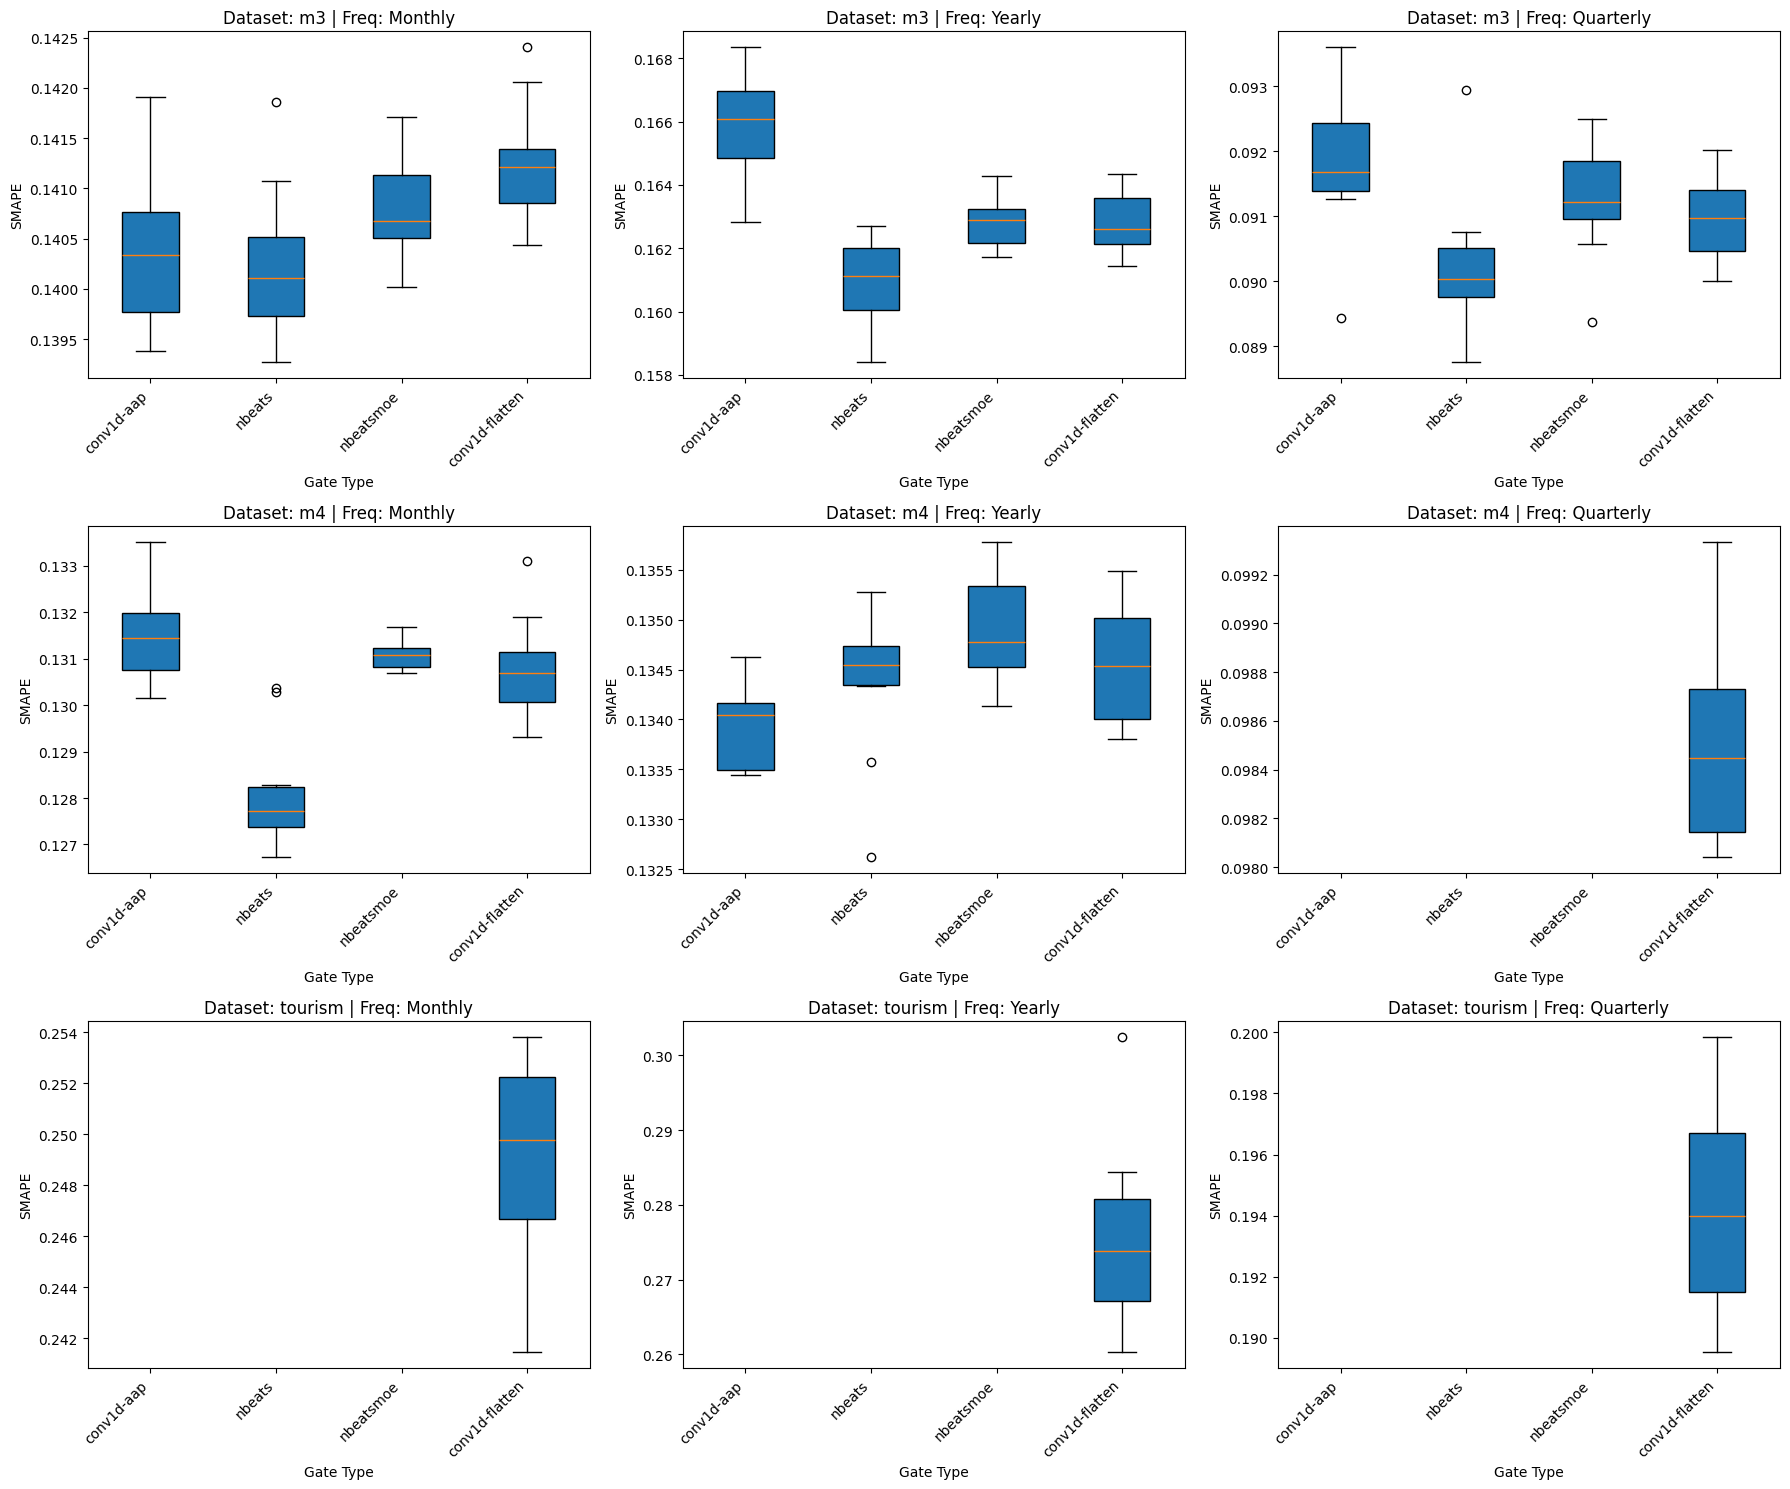

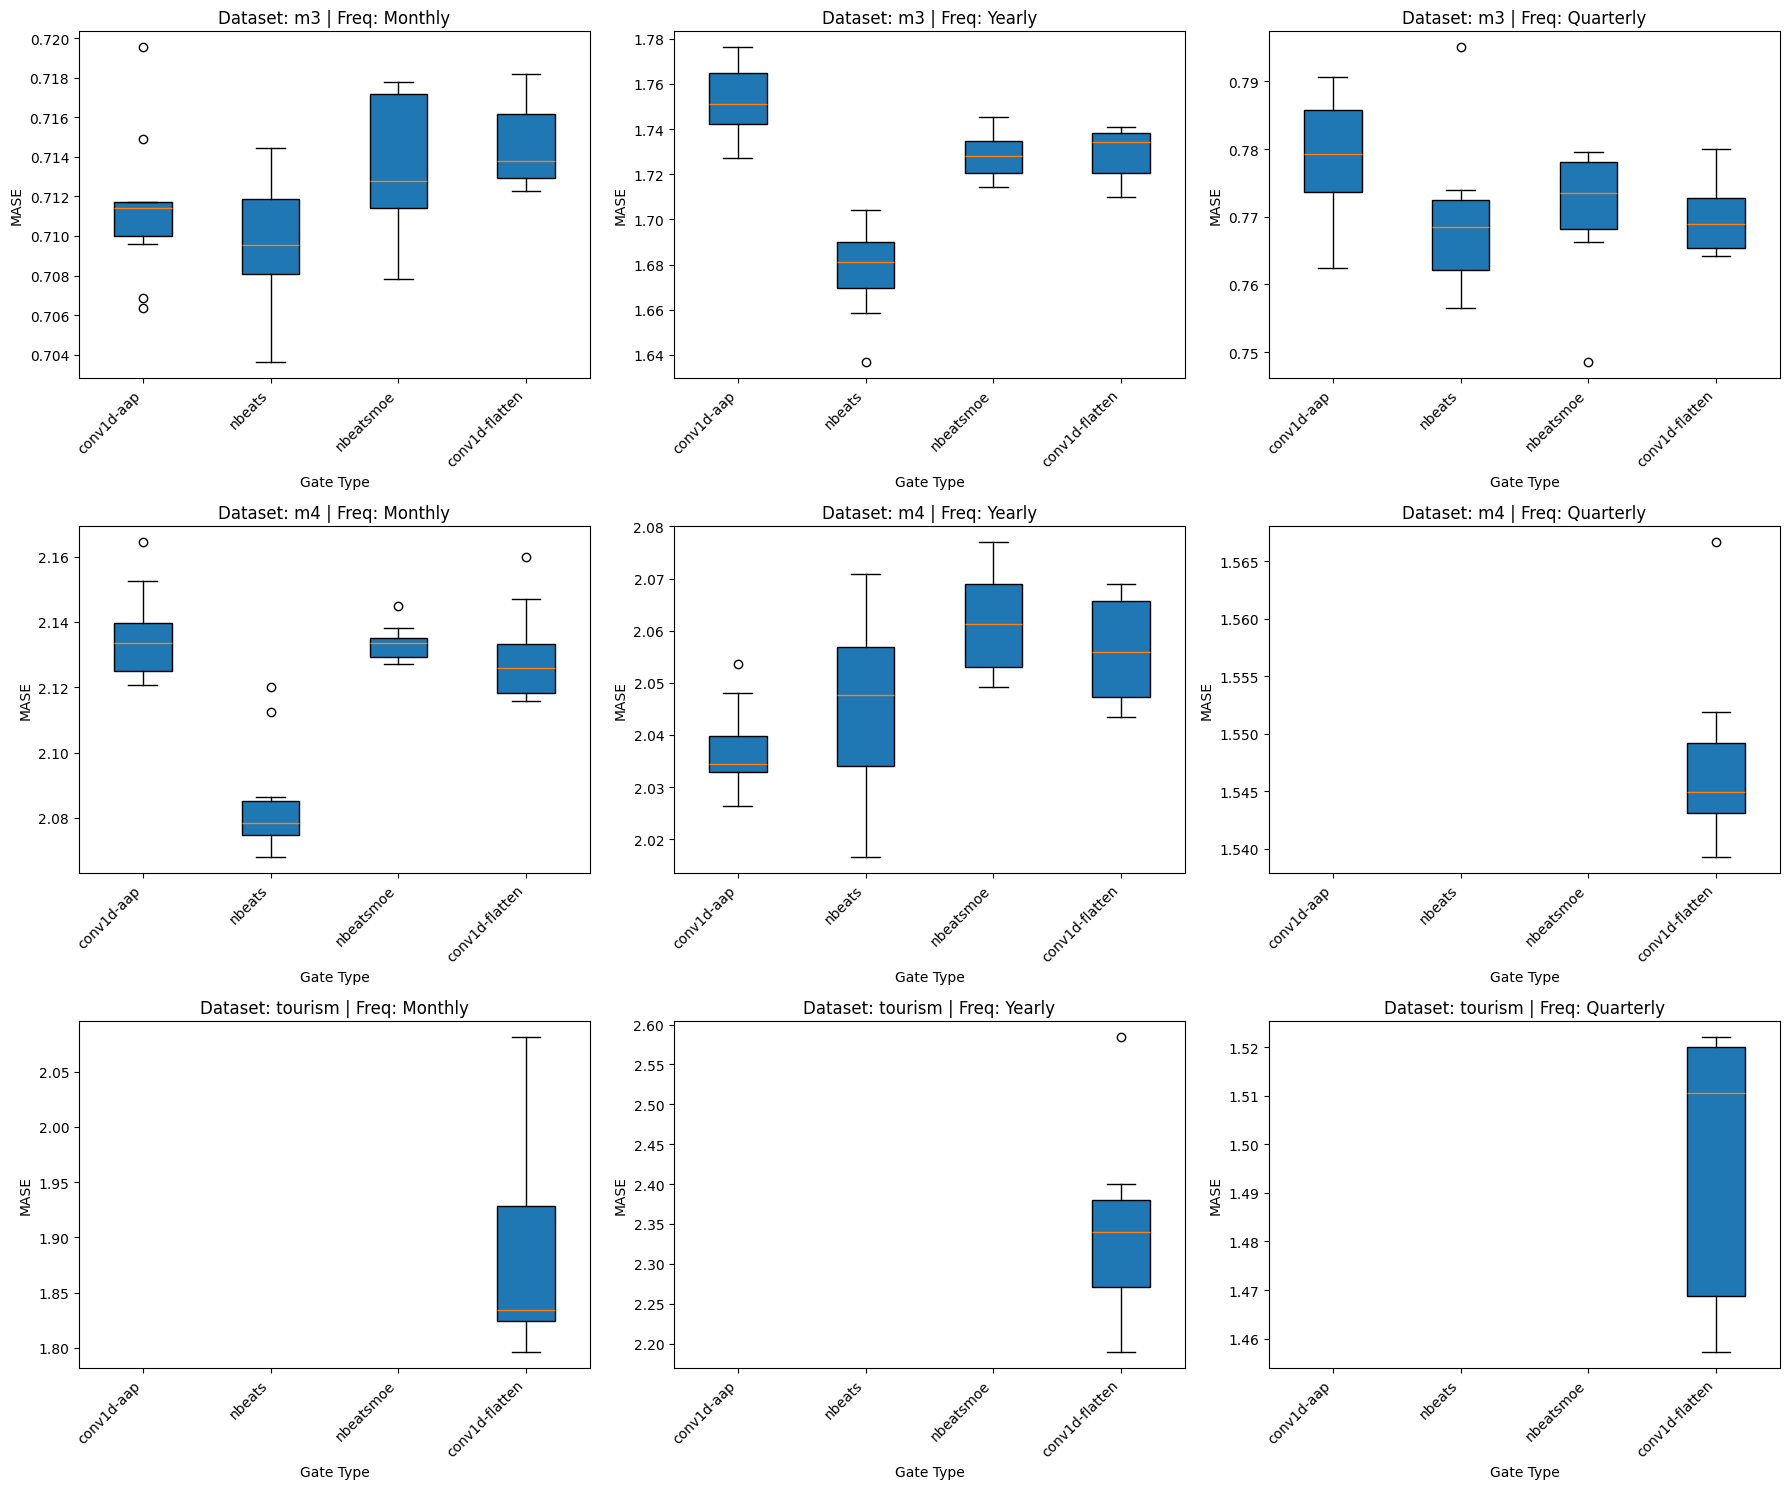

In [45]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['smape', 'mase']
datasets_unique = results_df['dataset'].unique()
freqs_unique = results_df['freq'].unique()
gate_types = results_df['gate_type'].unique()

n = len(datasets_unique) * len(freqs_unique)
n_cols = len(freqs_unique)
n_rows = len(datasets_unique)

for metric in metrics:
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), squeeze=False)

    for i, dataset in enumerate(datasets_unique):
        for j, freq in enumerate(freqs_unique):
            ax = axes[i][j]
            subset = results_df[(results_df['dataset'] == dataset) & (results_df['freq'] == freq)]

            data_to_plot = []
            labels = []

            for gate in gate_types:
                values = subset[subset['gate_type'] == gate][metric].values
                data_to_plot.append(values)
                labels.append(gate)

            ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
            ax.set_title(f'Dataset: {dataset} | Freq: {freq}')
            ax.set_xlabel('Gate Type')
            ax.set_ylabel(metric.upper())
            ax.set_xticklabels(labels, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()
